# Fluvial Sedimentary Response to Large Deep-Seated Landslide Event(s)
## CSDMS ESPIn 2024 Lab: Event-Sediment-Pulse Team
Contributors (listed in the alphabetic order of last name): 
- **Nilay Iscen**          *(University of Minnesota, St. Anthony Falls Laboratory)*
- **John Kemper**          *(Utah State University, Department of Watershed Sciences)*
- **Larry Syu-Heng Lai**   *(University of Washington, Department of Earth and Space Sciences)*
- **Yuan Li**              *(University of Virginia, Department of Environmental Sciences)*

---

## Introduction

Watersheds are increasingly understood to function as connected networks, with the strength of connections between landscape compartments – for example, hillslopes and river channels – controlling various system dynamics (Figure 1) (Fryirs, 2013). In mountain landscapes, where catastrophic hillslope processes like landslides are important and potentially fairly frequent events, the response of a particular watershed to a spate of landslide activity is likely strongly influenced by this coupling. The strength of this coupling is controlled, at least in part, by the hydrology of the watershed in question. In relatively dry landscapes (like, for example, the semi-arid Colorado Front Range or the mesas of the Colorado Western Slope (Figure 2, right-hand side)), landslides that occur may be largely disconnected from valley bottom rivers, with sediment deposits that remain stored on hillslopes for many years, safe from the hydrologic highway offered by steep mountain rivers. Conversely, in relatively wet landscapes (like, for example, Taiwan or Pacific Northwest (Figure 2, left-hand side)), landslides may be fairly well-connected to valley bottom rivers, with landslide-generated sediment transported relatively quickly downslope by subsequent rainfall events. The time it takes for these two landscapes to transport sediment produced by landslides is thus likely very different: in the former, it may take centuries to evacuate, whereas in the latter, a pronounced sediment response may occur in the years immediately following hillslope failure. The time scale of response is important for many reasons, including short-term management concerns – like anticipating how long river flooding may occur following large mass movement events – to long-term landscape development questions – like how landslides influence downstream river erosion and the form and shape of mountain landscapes. 

<img src="connectivity_img.jpg" alt="drawing" width="400"/>

*Figure 1. A graphical depiction of connectivity, with barriers to connectivity (i.e., low connectivity) represent by red symbols*

<img src="MotivationImg.jpg" alt="drawing" width="800"/>

*Figure 2. Left: 2014 Oso Landlside, WA (Source: The Seattle Times) Right: 2014 West Salt Creek Landslide, CO (Source: USGS)*

---


In this notebook, we will simulate these sorts of different landscapes using `Landlab` v2.7 and various components. We will do this by running the following two hillslope-river connectivity scenarios to investigate how the river network may respond to an catastrophic landslide period: 

1.	High-connectivity scenario: Here, we simulate landslide occurrence over a 20-year period that occurs simultaneously with fluvial processes (flow routing, erosion, etc.). This represents our wet landscape, where landslide sediment is frequently transported downslope to river channels by rainfall events. We then run this same model forward 20 more years to see how the river network evacuates sediment in these sorts of well-connected landscapes. 

2.	Low-connectivity scenario: Here, we simulate landslide occurrence over the same 20-year period, but we turn off fluvial and hydrological processes, essentially "stranding" the landslide sediment on the hillslopes. This represents our dry landscape, where landslide-derived sediment may remain perched high above river channels. We then "turn on" hydrological and fluvial processes and run the model forward several years, to see how the river network evacuates sediment in these more poorly connected landscapes.

We will utilize the **`SPACE`**, **`GravelBedrockEroder`**, **`BedrockLandslider`**, and **`FlowAccumulator`** components to perform the analysis through following steps:

* Step 1: Setup an steady-state initial landscape before catastropic landslide event
    * Run simulation using `SPACE` model
    * Show the landform, sediment thickness, and river long-profile for the main trunk

* Step 2: Testing a scenario with **GOOD** hillslope-channel connectivity:
    * 2.1: Run simulation using both Hyland (`BedrockLandslider`) **and** `GravelBedrockEroder` in every iteration for 20 years
    * 2.2: Run `GravelBedrockEroder` only for 50, 100, 1000, 5000, 10000 years **after** the landslide event, and plot the results.

* Step 3: Testing a scenario with **BAD** hillslope-channel connectivity:
    * 3.1: Run simulation using Hyland (`BedrockLandslider`) only for 20 years - no river transport and incision.
    * 3.2: Run `GravelBedrockEroder` only for 50, 100, 1000, 5000, 10000 years **after** the landslide event, and plot the results.

* Step EXTRA: Testing a scenario **BAD** connectivity scenario with real landscape DEM:
    * EXTRA.1: Load and plot the real landscape DEM
    * EXTRA.2: Load and plot the DEM with imposed landslide event using Hyland (`BedrockLandslider`).
    * EXTRA.3: Run `GravelBedrockEroder` only for 50, 100, 1000, 5000, 10000 years **after** the landslide event, and plot the results.

References:
* Shobe, C. M., Tucker, G. E., and Barnhart, K. R.: The SPACE 1.0 model: a Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, Geosci. Model Dev., 10, 4577-4604, https://doi.org/10.5194/gmd-10-4577-2017, 2017. 
* Campforts, B., Shobe, C. M., Steer, P., Vanmaercke, M., Lague, D., and Braun, J.: HyLands 1.0: a hybrid landscape evolution model to simulate the impact of landslides and landslide-derived sediment on landscape evolution, Geosci. Model Dev., 13, 3863–3886, https://doi.org/10.5194/gmd-13-3863-2020, 2020.
* GravelBedrockEroder: rock incision, bed-load transport, and downstream abrasion in a river network. https://landlab.readthedocs.io/en/latest/reference/components/gravel_bedrock_eroder.html

---

### Importing necessary libraries and components:

In [2]:
# Import necessary libraries and components
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Import Landlab components
from landlab import RasterModelGrid
from landlab import imshow_grid
from landlab.components import BedrockLandslider  # For simulating landslides
from landlab.components import SpaceLargeScaleEroder  # For simulating fluvial erosion
from landlab.components import PriorityFloodFlowRouter  # For routing flow
from landlab.components import GravelBedrockEroder  # For simulating bedrock erosion
from landlab.components import ChannelProfiler  # For extracting channel profiles

# For saving and loading landlab grid objects
import pickle

### Define plotting functions for long-profile of the trunk channel and landscape evolution:

In [3]:
def plot_landscape_and_profile(mg, title="Landscape and Profile"):
    """
    Plot landscape evolution and long profile in a single figure.
    Upper panel: Terrain & Channels (left) and Soil depth (right)
    Lower panel: Long profile of the trunk channel
    
    Parameters:
    - mg: Landlab model grid
    - title: Title for the entire figure
    """
    # Create figure and gridspec for layout
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

    # Upper left: Terrain & Channels
    ax1 = fig.add_subplot(gs[0, 0])
    # Initialize ChannelProfiler to extract channel network
    profiler = ChannelProfiler(mg, number_of_watersheds=1, minimum_channel_threshold=625, main_channel_only=True)
    profiler.run_one_step()
    cmap_terrain = copy.copy(mpl.colormaps["terrain"])
    plt.sca(ax1)
    profiler.plot_profiles_in_map_view(cmap=cmap_terrain)
    ax1.set_title("Terrain & Channels")

    # Upper right: Soil depth
    ax2 = fig.add_subplot(gs[0, 1])
    cmap_pink = copy.copy(mpl.colormaps["pink"])
    plt.sca(ax2)
    im = imshow_grid(
        mg,
        mg.at_node["soil__depth"],
        colorbar_label="Soil depth (m)",
        cmap=cmap_pink
    )
    ax2.set_title("Soil depth")

    # Lower: Long profile
    ax3 = fig.add_subplot(gs[1, :])
    ax4 = ax3.twinx()  # Create a twin axis for sediment thickness

    # Extract data for the main channel
    riv_nodes = profiler.nodes[0]  # Main channel nodes
    mg.at_node["bedrock_elevation"] = mg.at_node["topographic__elevation"] - mg.at_node["soil__depth"]
    dist_atNodes = profiler.distance_along_profile[0]

    el = mg.at_node["topographic__elevation"][riv_nodes]
    sd = mg.at_node["soil__depth"][riv_nodes]
    br = el - sd

    # Calculate relief
    min_elevation = min(np.min(el), np.min(br), 0)
    el_relief = el - min_elevation
    br_relief = br - min_elevation

    # Convert distance to km
    dist = (max(dist_atNodes) - dist_atNodes) * 1e-3
    brown_c = [205/255, 133/255, 63/255]  # Color for colluvial material

    # Plot relief and soil depth
    ax3.fill_between(dist, np.max(el_relief), 0, color='lightgrey', label='total area')
    ax3.fill_between(dist, br_relief, 0, color='grey', label='bedrock')
    ax3.fill_between(dist, el_relief, br_relief, color=brown_c, label='colluvial material')

    lns2 = ax3.plot(dist, br_relief, color='k', label='bedrock', linewidth=0.8, zorder=3)
    lns1 = ax3.plot(dist, el_relief, color='brown', label='topo', linewidth=1, zorder=4)

    ax3.set_xlabel('Distance Along Profile (km)', fontweight='normal', fontsize=10.0)
    ax3.set_ylabel('Relief (m)', fontweight='normal', fontsize=10.0)
    ax3.set_ylim((np.min(el_relief), np.max(el_relief) * 1.1))
    ax3.tick_params(labelsize=10.0)

    # Plot sediment thickness on the twin axis
    lns3 = ax4.plot(dist, sd, color='orange', label='sediment', linewidth=0.8)
    ax4.set_ylabel('Sediment thickness (m)', fontweight='normal', fontsize=10.0)
    ax4.set_ylim((0, np.nanmax(sd) * 1.4))
    ax4.tick_params(labelsize=10.0)

    # Combine legends
    lns = lns1 + lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax3.legend(lns, labs, fontsize=10.0)
    ax3.set_ylim(bottom=0)

    ax3.set_title("Long Profile of Main Trunk")

    plt.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.show()

### Model Setup and Initialization

Now, let's set up our model grid and initialize the components. We'll create functions to handle these tasks:

In [4]:
def setup_model_grid(num_rows=30, num_columns=30, node_spacing=25.0):
    """
    Set up the initial model grid.
    
    Parameters:
    - num_rows: Number of rows in the grid
    - num_columns: Number of columns in the grid
    - node_spacing: Spacing between nodes
    
    Returns:
    - mg: Initialized Landlab RasterModelGrid
    """
    # Create the grid
    mg = RasterModelGrid((num_rows, num_columns), node_spacing)
    
    # Add fields to the grid
    mg.add_zeros("topographic__elevation", at="node")
    mg.add_zeros("soil__depth", at="node")
    mg.add_zeros("bedrock__elevation", at="node")

    # Add random noise to topography for initial roughness
    random_noise = (np.random.rand(len(mg.node_y)) / 1000.0)
    mg["node"]["topographic__elevation"] += random_noise
    
    # Set initial soil depth (1m) at core nodes
    mg.at_node["soil__depth"][mg.core_nodes] = 1.0
    
    # Calculate bedrock elevation as the difference between topographic elevation and soil depth
    mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
    mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

    # Set boundary conditions: closed on all sides except one outlet
    mg.set_closed_boundaries_at_grid_edges(True, True, True, True)
    mg.status_at_node[0] = 1  # Set outlet at node 0

    return mg

In [5]:
def initialize_components(mg):
    """
    Initialize model components.
    
    Parameters:
    - mg: Landlab RasterModelGrid
    
    Returns:
    - fr: Initialized FlowRouter
    - sp: Initialized SpaceLargeScaleEroder
    """
    # Initialize flow router with D8 flow direction method
    fr = PriorityFloodFlowRouter(mg, flow_metric="D8", suppress_out=True)
    
    # Initialize SPACE component for sediment transport and bedrock erosion
    sp = SpaceLargeScaleEroder(
        mg,
        K_sed=2.5e-5,  # Erodibility coefficient for sediment
        K_br=2.5e-5,   # Erodibility coefficient for bedrock
        F_f=0.0,       # Fraction of fine sediment
        phi=0.0,       # Sediment porosity
        H_star=1.0,    # Sediment thickness required for full entrainment
        v_s=1,         # Settling velocity
        m_sp=0.5,      # Drainage area exponent
        n_sp=1.0,      # Slope exponent
        sp_crit_sed=0, # Critical shear stress for sediment
        sp_crit_br=0,  # Critical shear stress for bedrock
    )
    return fr, sp

### Simulation Functions

Now let's define our main simulation functions for different scenarios:

In [6]:
def run_initial_landscape(mg, fr, sp, run_time=500000, timestep=500, U=0.001):
    """
    Run simulation to generate the initial semi-steady-state landscape.
    
    Parameters:
    - mg: Landlab RasterModelGrid
    - fr: FlowRouter component
    - sp: SpaceLargeScaleEroder component
    - run_time: Total simulation time
    - timestep: Time step for each iteration
    - U: Uplift rate (m/year)
    """
    elapsed_time = 0.0
    while elapsed_time < run_time:
        # Apply uplift to bedrock and update topography
        mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
        mg.at_node["topographic__elevation"][:] = (
            mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
        )
        
        # Route flow and perform erosion/deposition
        fr.run_one_step()
        sp.run_one_step(dt=timestep)
        
        elapsed_time += timestep
        # Print progress every 100,000 years
        if np.mod(elapsed_time, 1e5) == 0:
            print(f"{100 * elapsed_time / run_time:.0f}% of model run completed")

In [7]:
def run_good_connectivity_scenario(mg, timesteps=20, timestep=1, landsliding=True, U=0.001):
    """
    Run the good connectivity scenario with simultaneous landslides and river incision.
    
    Parameters:
    - mg: Landlab RasterModelGrid
    - timesteps: Number of time steps to run
    - timestep: Duration of each time step
    - landsliding: Boolean to enable/disable landsliding
    - U: Uplift rate (m/year)
    """
    # Initialize flow router with both channel and hillslope flow
    fr = PriorityFloodFlowRouter(
        mg,
        flow_metric="D8",
        separate_hill_flow=True,
        hill_flow_metric="Quinn",
        update_hill_flow_instantaneous=True,
    )
    
    # Initialize landslide component
    hy = BedrockLandslider(
        mg,
        angle_int_frict=0.4,  # Internal friction angle
        cohesion_eff=1e3,     # Effective cohesion
        landslides_return_time=1000,  # Average time between landslides
        landslides_on_boundary_nodes=False,
    )
    
    # Initialize gravel-bed river erosion component
    eroder = GravelBedrockEroder(
        mg, 
        abrasion_coefficient=0.0005,  # Rate of downstream fining
        coarse_fraction_from_plucking=0.1  # Fraction of plucked material that becomes coarse sediment
    )

    for _ in range(timesteps):
        # Apply uplift and update topography
        mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
        mg.at_node["topographic__elevation"][:] = (
            mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
        )
        
        # Route flow and perform erosion
        fr.run_one_step()
        eroder.calc_sediment_rate_of_change()
        eroder.run_one_step(timestep)
        
        # Trigger landslides if enabled
        if landsliding:
            hy.run_one_step(dt=timestep)

In [8]:
def run_bad_connectivity_scenario(mg, landslide_steps=20, river_steps=20, timestep=1, U=0.002):
    """
    Run the bad connectivity scenario with landslides followed by river incision.
    
    Parameters:
    - mg: Landlab RasterModelGrid
    - landslide_steps: Number of time steps for landslide phase
    - river_steps: Number of time steps for river incision phase
    - timestep: Duration of each time step
    - U: Uplift rate (m/year)
    """
    # Initialize components (same as in good connectivity scenario)
    fr = PriorityFloodFlowRouter(
        mg,
        flow_metric="D8",
        separate_hill_flow=True,
        hill_flow_metric="Quinn",
        update_hill_flow_instantaneous=True,
    )
    hy = BedrockLandslider(
        mg,
        angle_int_frict=0.4,
        cohesion_eff=1e3,
        landslides_return_time=1000,
        landslides_on_boundary_nodes=False,
    )
    eroder = GravelBedrockEroder(
        mg, abrasion_coefficient=0.0005,
        coarse_fraction_from_plucking=0.1
    )

    # Landslide phase: only uplift and landslides, no river erosion
    for _ in range(landslide_steps):
        mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
        mg.at_node["topographic__elevation"][:] = (
            mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
        )
        hy.run_one_step(dt=timestep)

    # River incision phase: uplift, flow routing, and river erosion
    for _ in range(river_steps):
        mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
        mg.at_node["topographic__elevation"][:] = (
            mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
        )
        fr.run_one_step()
        eroder.calc_sediment_rate_of_change()
        eroder.run_one_step(timestep)

<hr>

### Main Execution

Now, let's run our simulations for the different scenarios:

##### Step 1: Create initial landscape

Generating the Pre-slide Synthetic Landscape via SPACE model
20% of model run completed
40% of model run completed
60% of model run completed
80% of model run completed
100% of model run completed
Pre-slide Synthetic Landscape


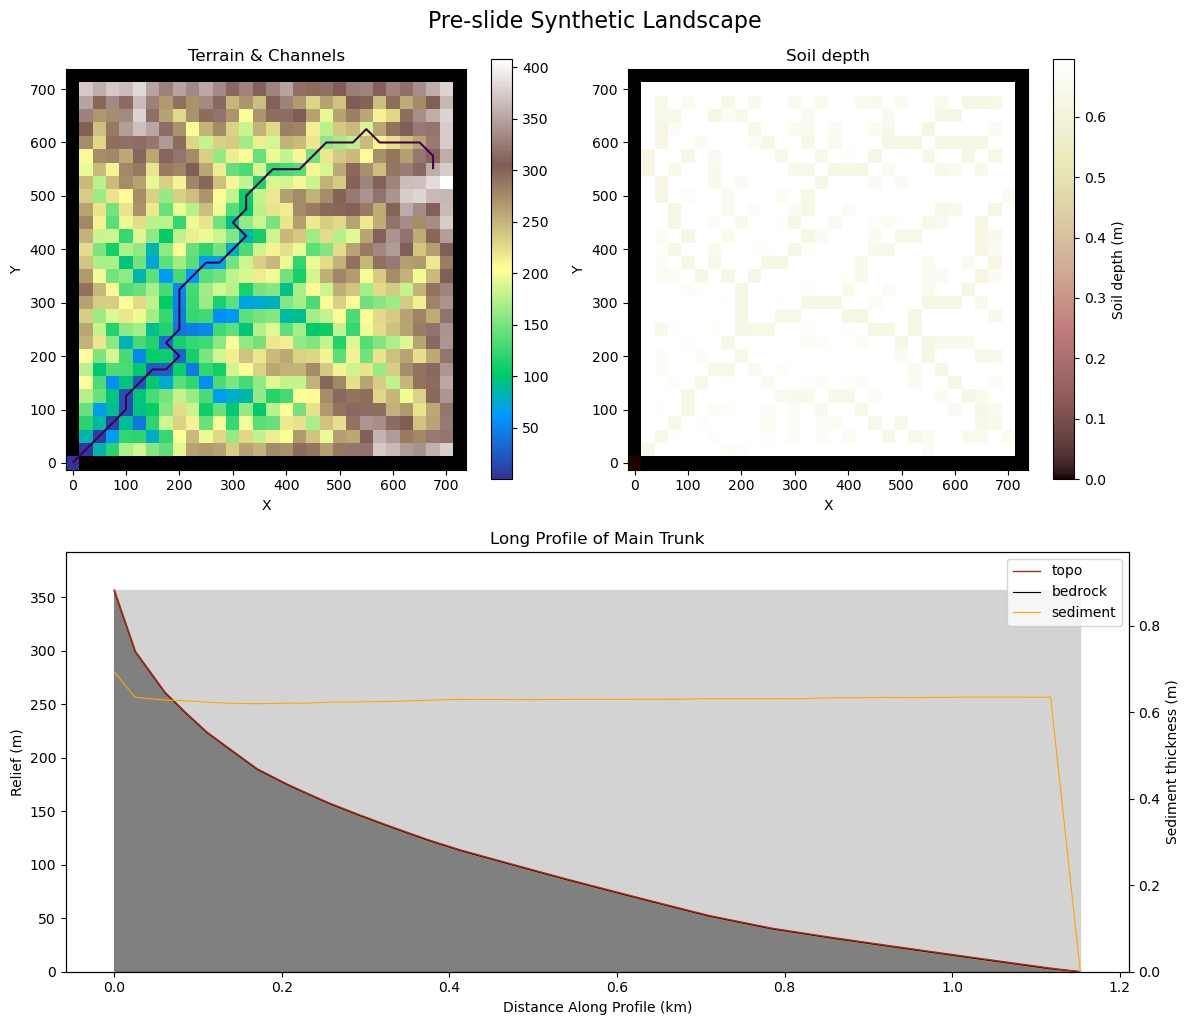

In [9]:
print("Generating the Pre-slide Synthetic Landscape via SPACE model")
mg = setup_model_grid()
fr, sp = initialize_components(mg)
run_initial_landscape(mg, fr, sp)

# Save initial landscape
with open('pre-slide_fakelandscape.pickle', 'wb') as f:
    pickle.dump(mg, f)

# Plot initial landscape
print("Pre-slide Synthetic Landscape")
plot_landscape_and_profile(mg, "Pre-slide Synthetic Landscape")

In [10]:
# Define the duration of catastrophic landslide period
landslide_duration = 20  # years

##### Step 2: Good connectivity scenario

Post-Slide Synthetic Landscape - GOOD CONNECTIVITY


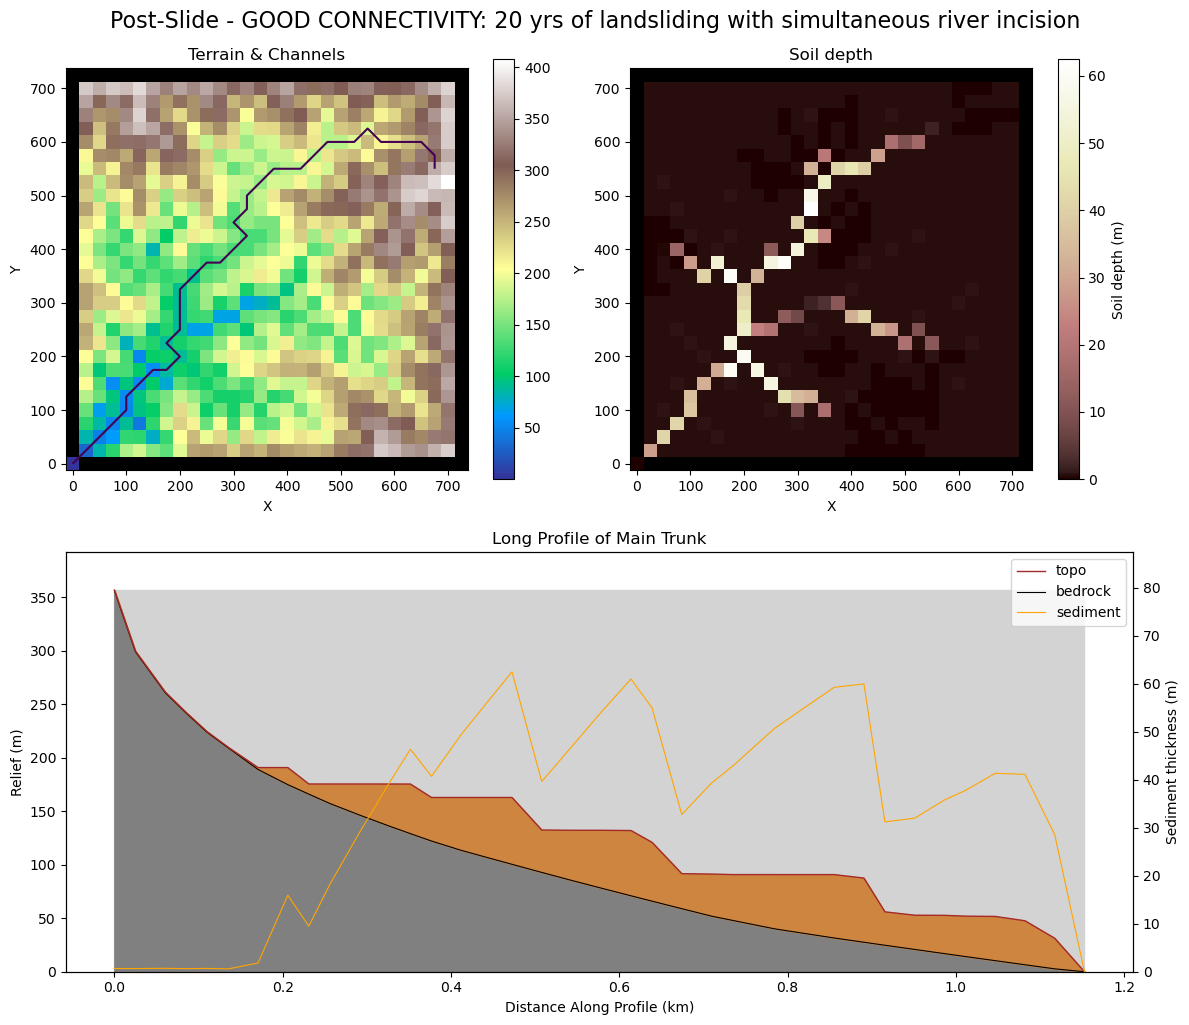

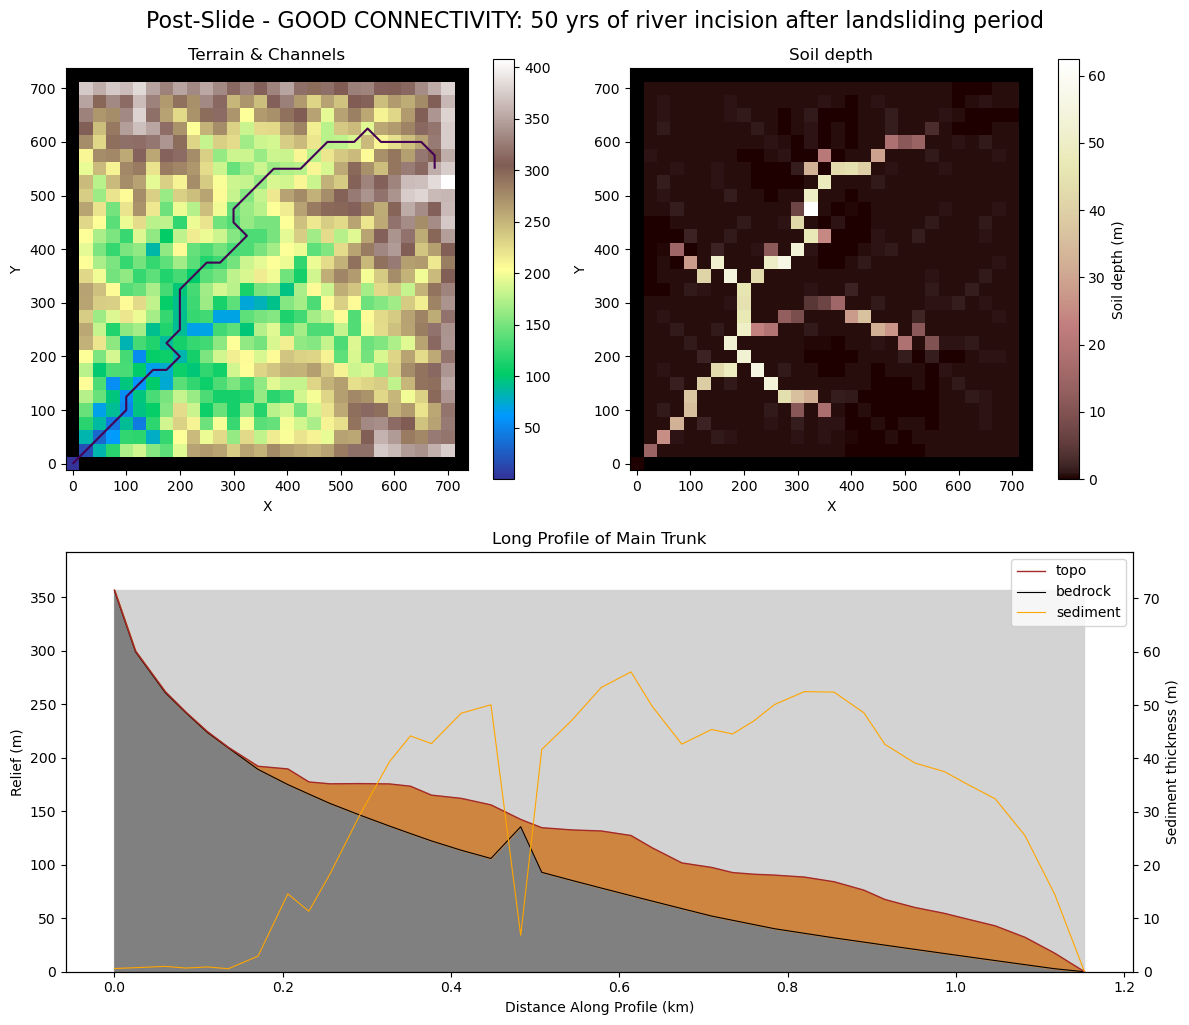

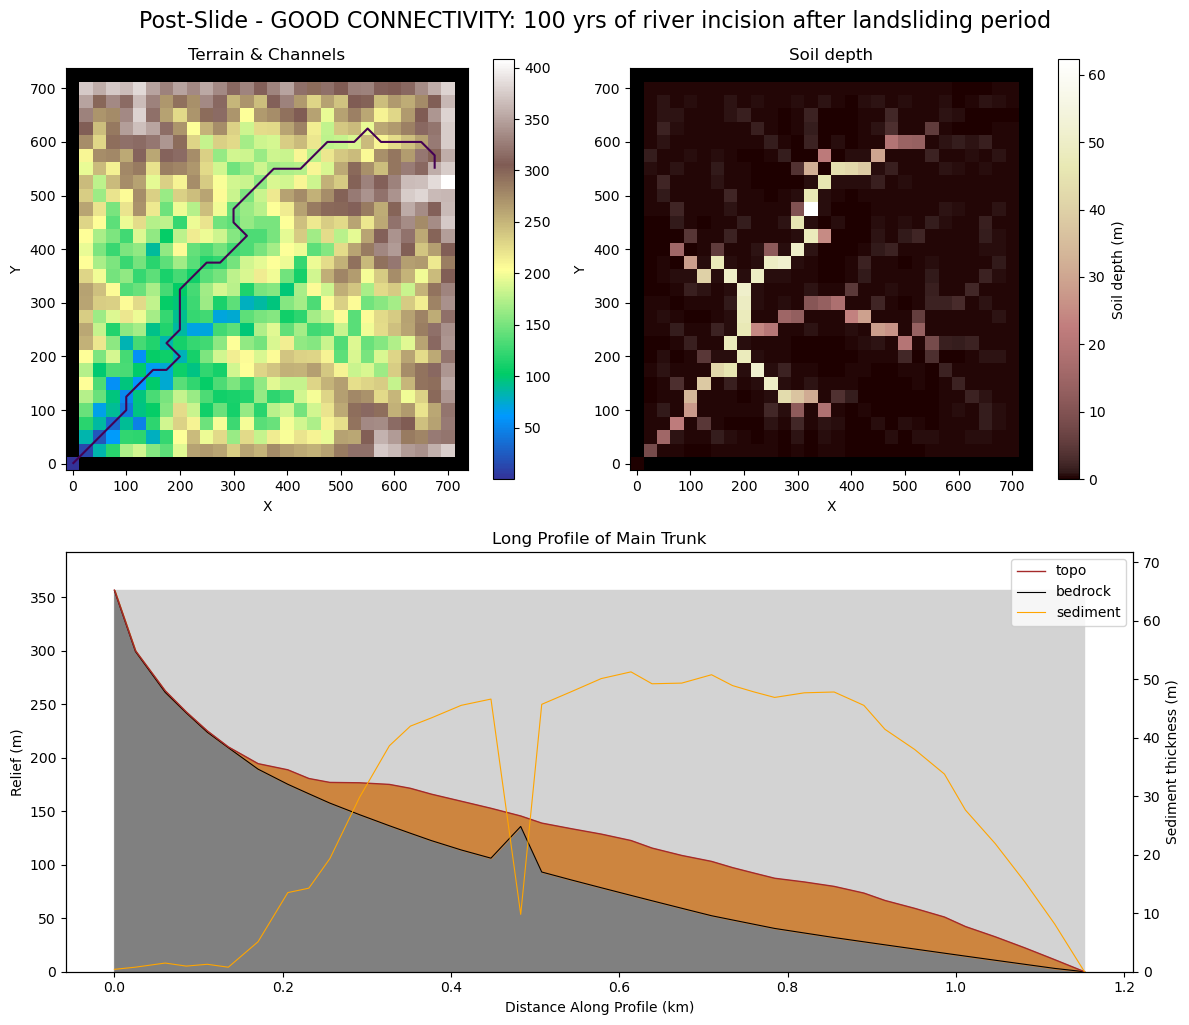

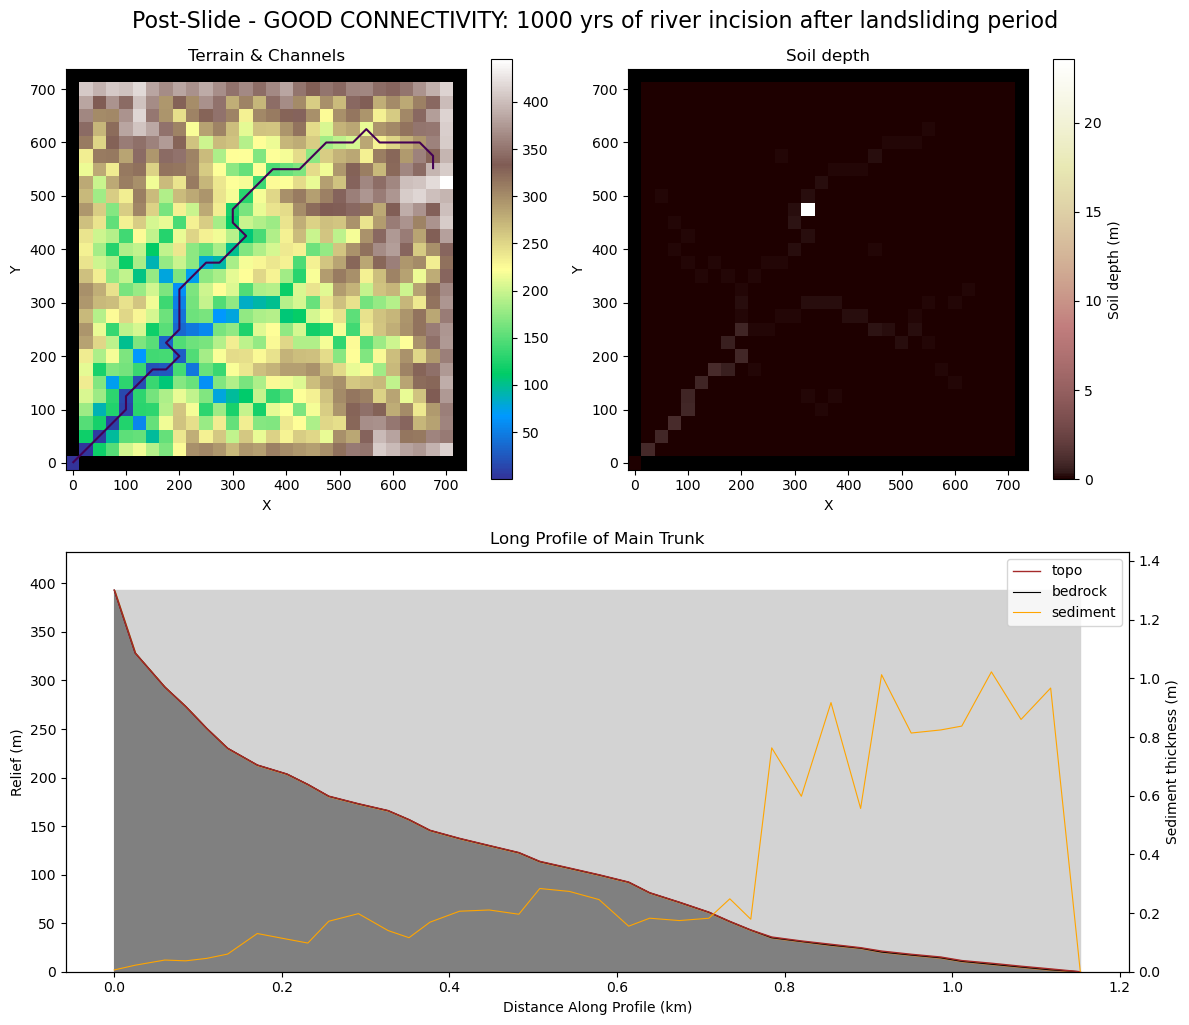

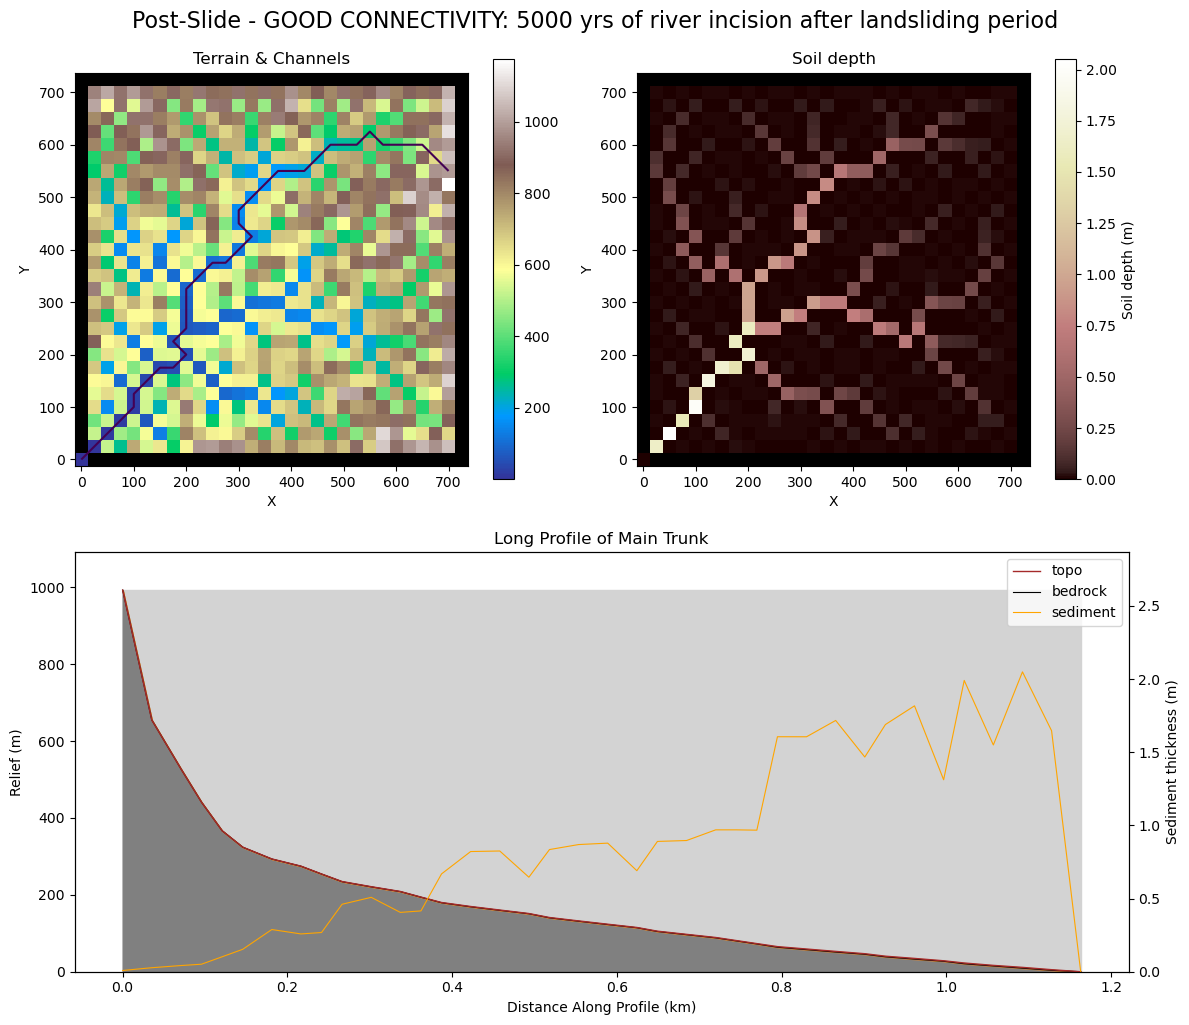

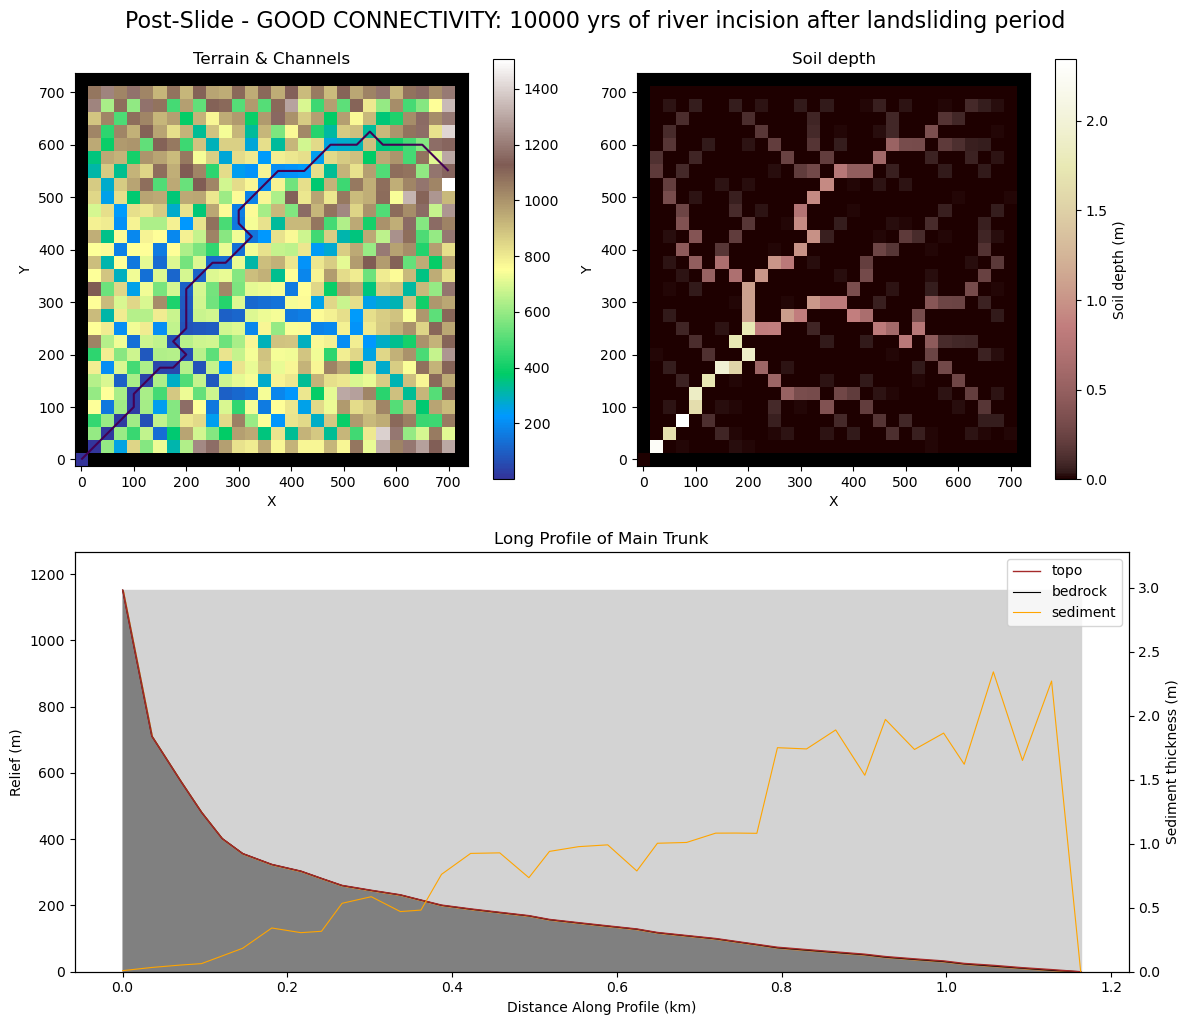

In [11]:
print("Post-Slide Synthetic Landscape - GOOD CONNECTIVITY")

# Run simulation for the first few years when landsliding and river incision are both active
mg_good = pickle.load(open('pre-slide_fakelandscape.pickle', 'rb'))  # Load the initial landscape
run_good_connectivity_scenario(mg_good, timesteps=landslide_duration, timestep = 1, landsliding=True)
plot_landscape_and_profile(mg_good, f"Post-Slide - GOOD CONNECTIVITY: {landslide_duration} yrs of landsliding with simultaneous river incision")  
with open('post-slide_fakelandscape_GoodConnect.pickle', 'wb') as f:  # Save good-connectivity post-slide landscape
    pickle.dump(mg_good, f)

# Shut down landlides, and continue to run simulation with only river incision
for years in [50, 100, 1000, 5000, 10000]:
    mg_good = pickle.load(open('post-slide_fakelandscape_GoodConnect.pickle', 'rb'))  # Load the good-connectivity post-slide landscape for each run
    run_good_connectivity_scenario(mg_good, timesteps=years, timestep = years/25, landsliding=False)
    plot_landscape_and_profile(mg_good, f"Post-Slide - GOOD CONNECTIVITY: {years} yrs of river incision after landsliding period")

***Notes:***

You may think >30-50 meters of landslide deposit is unrealistic, but here is a great example showing > ~80 m deposit generated by a single landslide event at southwestern Taiwan in 2009:

<img src="shiaolinTWslide.jpg" alt="drawing" width="600"/>
 
*2009 Shaolin Landlside, Taiwan (image from AGU: https://blogs.agu.org/landslideblog/2010/02/02/the-causes-of-the-shiaolin-landslide-disaster-in-taiwan/)*

##### Step 3: Bad connectivity scenario

Post-Slide Synthetic Landscape - BAD CONNECTIVITY


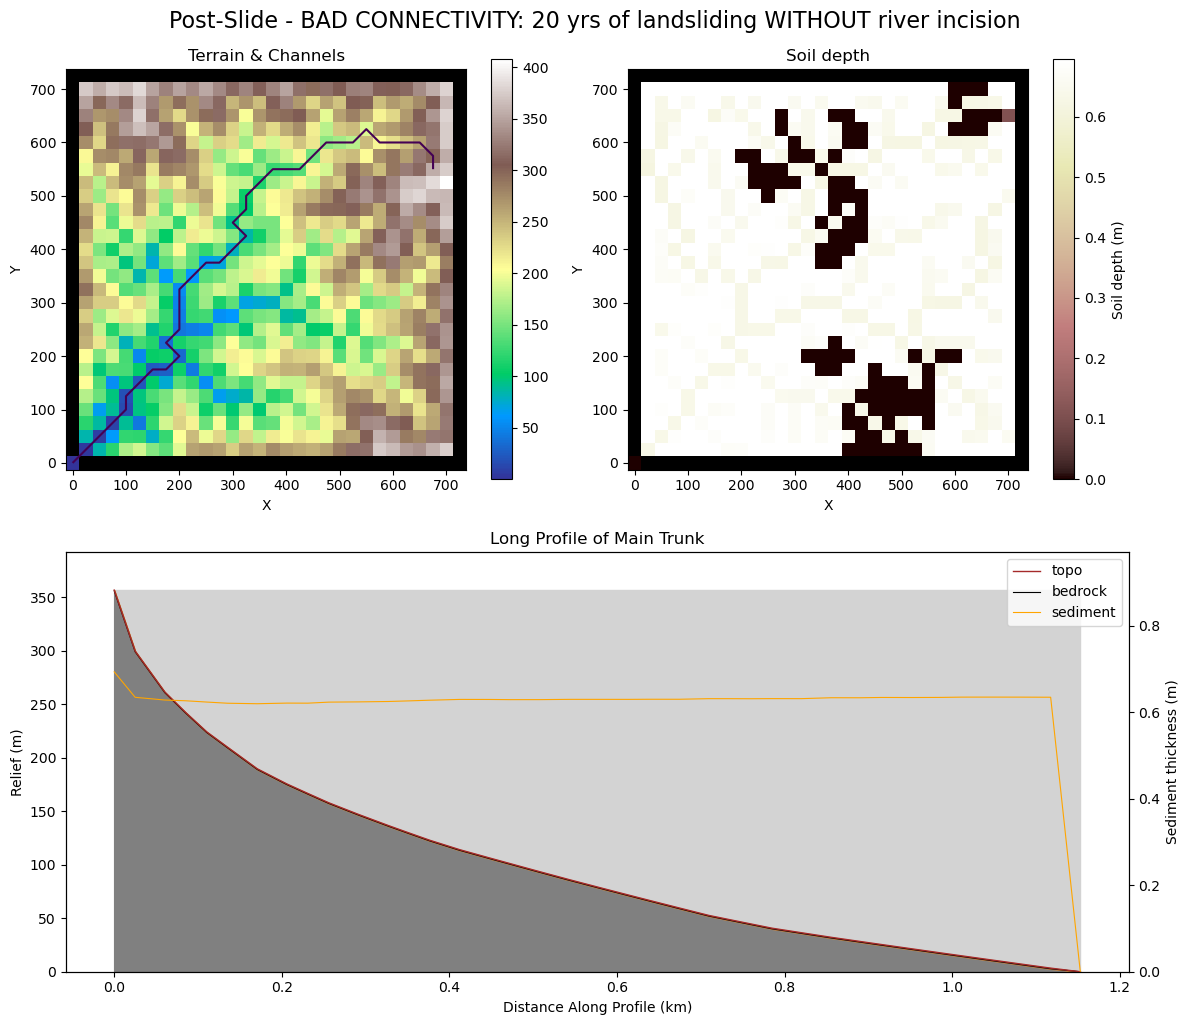

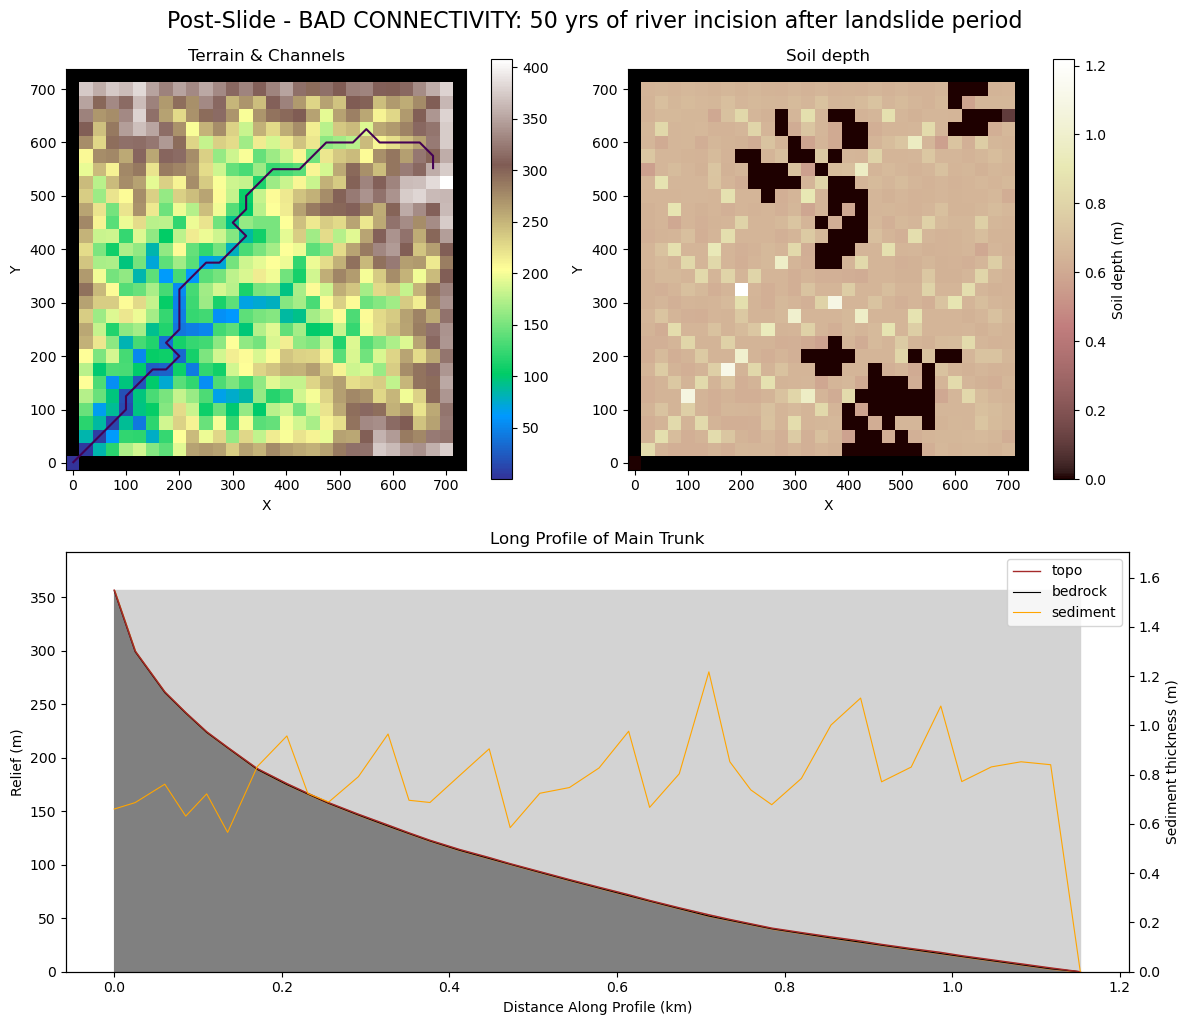

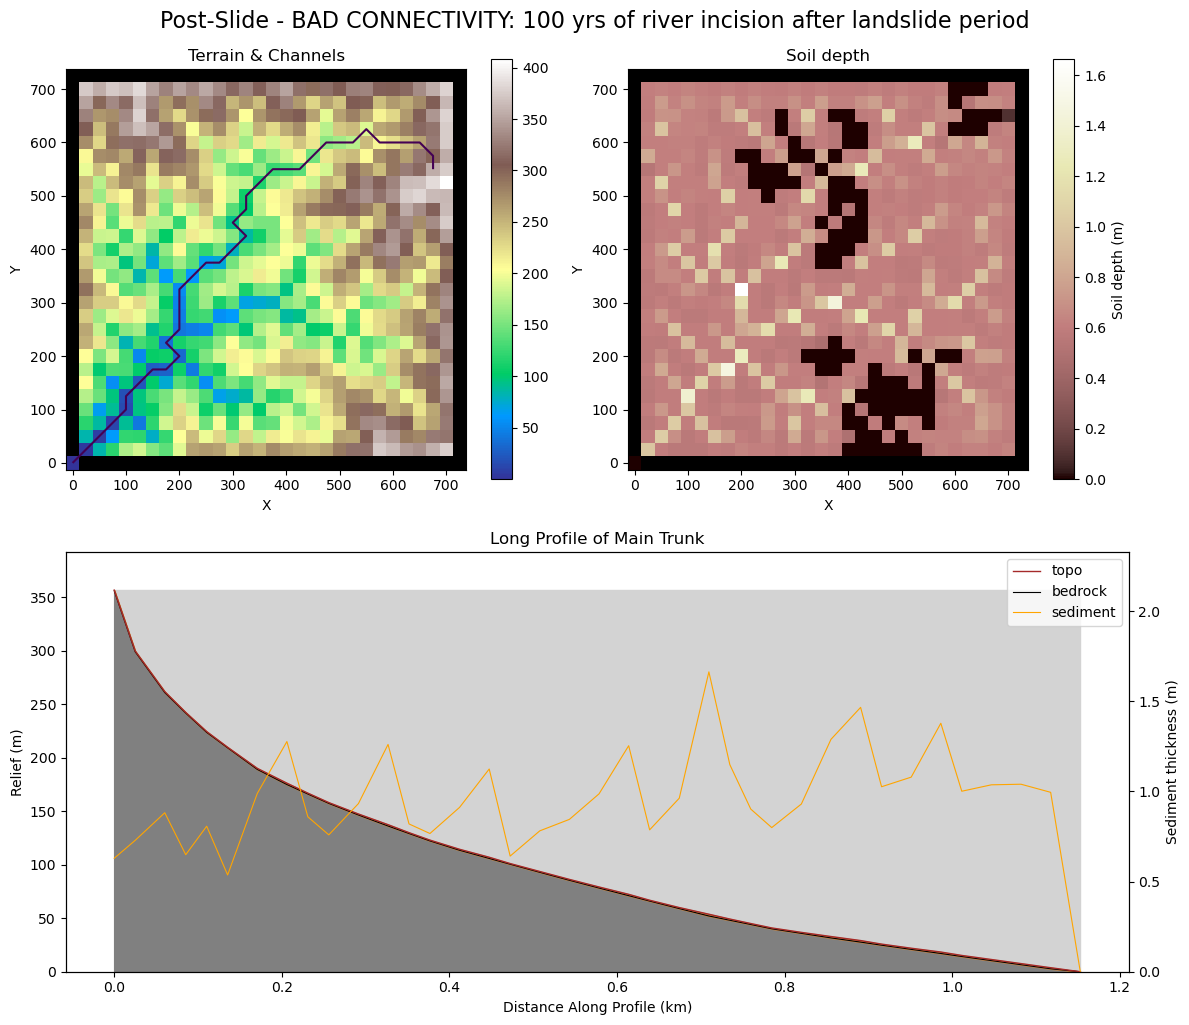

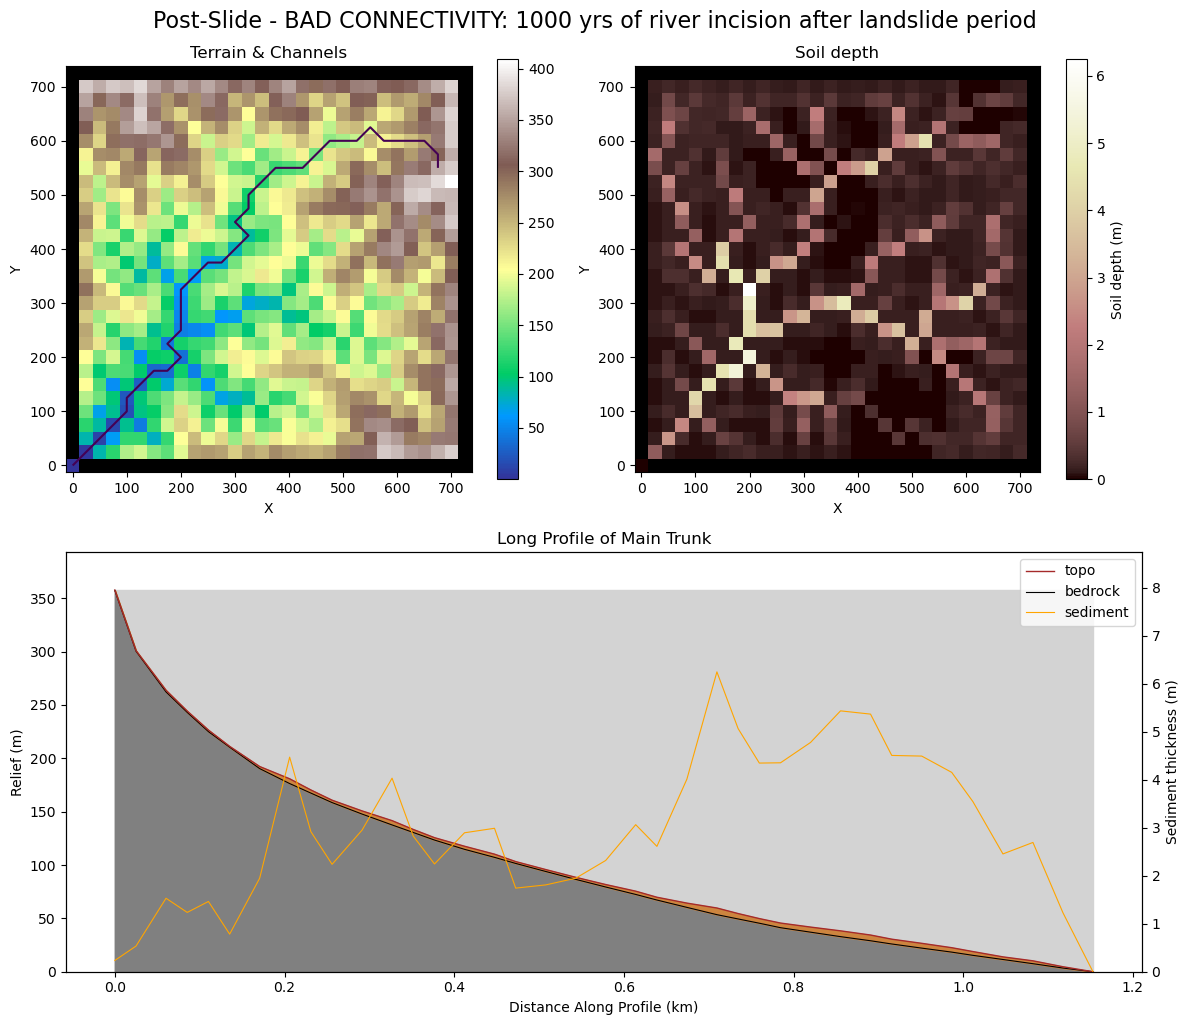

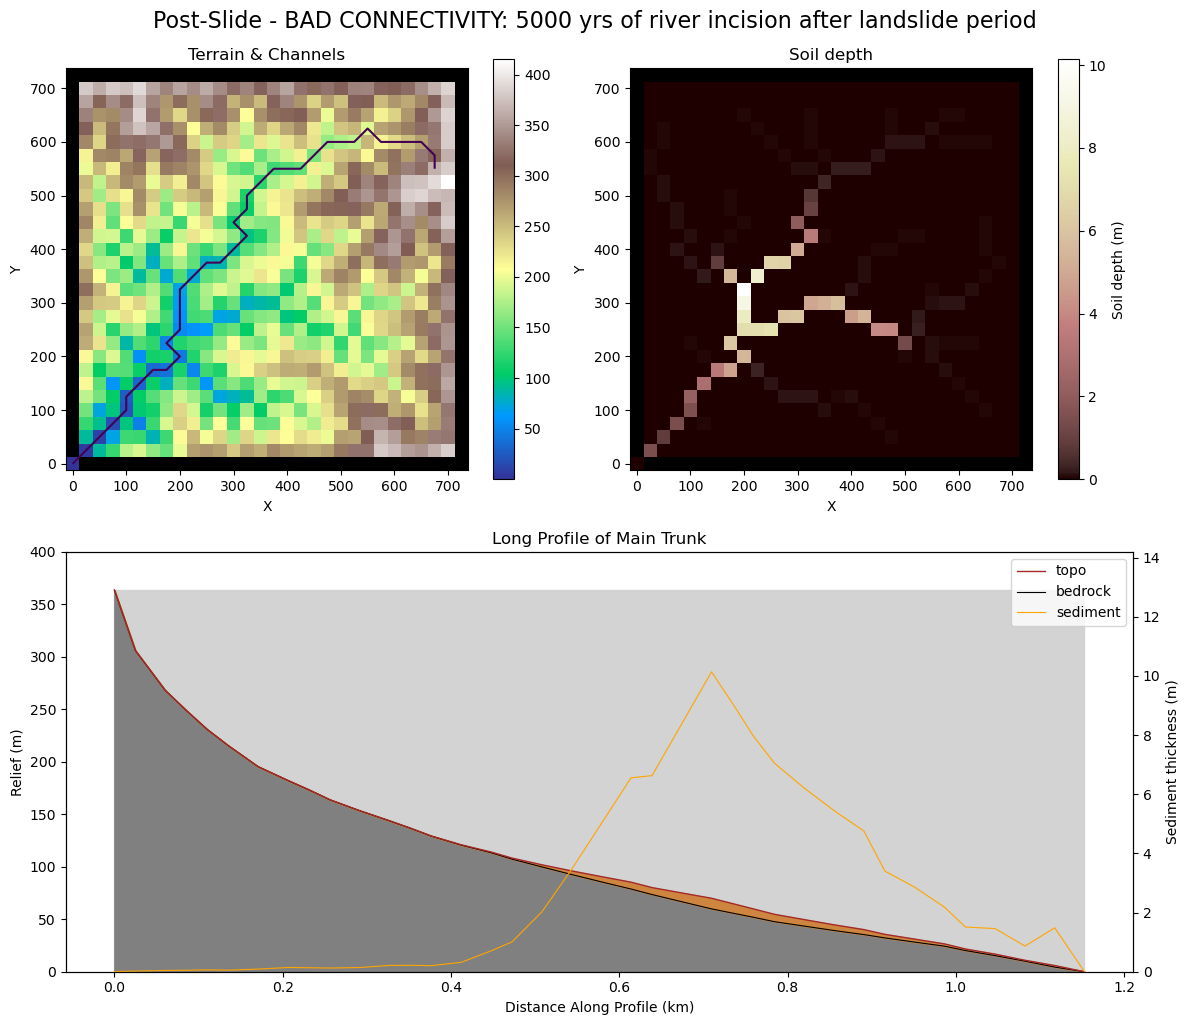

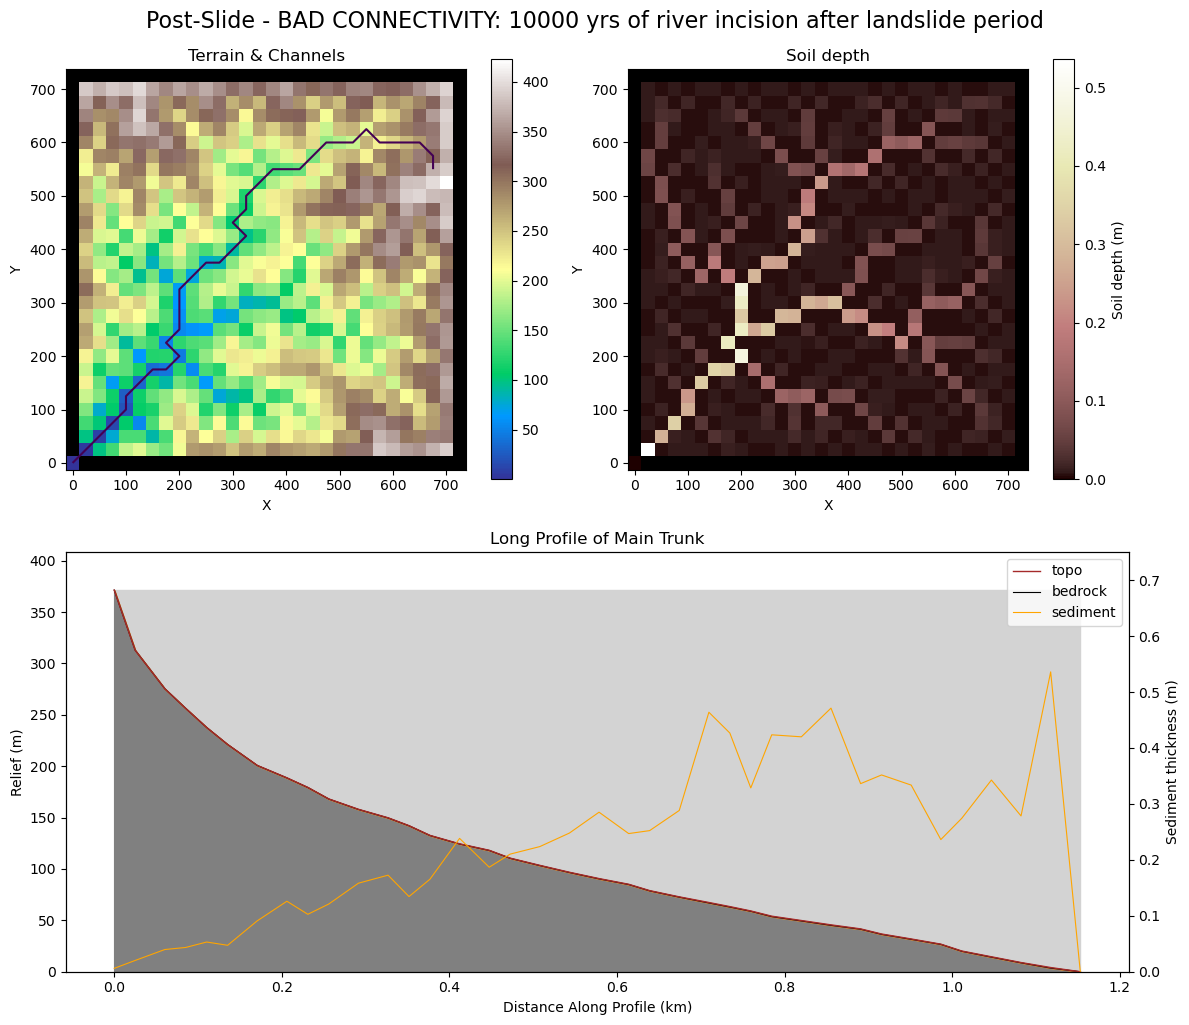

In [12]:
print("Post-Slide Synthetic Landscape - BAD CONNECTIVITY")

# Run landslides event first without river incision
mg_bad = pickle.load(open('pre-slide_fakelandscape.pickle', 'rb'))   # Load the initial landscape
run_bad_connectivity_scenario(mg_bad, landslide_steps=landslide_duration, river_steps=0)
plot_landscape_and_profile(mg_bad, f"Post-Slide - BAD CONNECTIVITY: {landslide_duration} yrs of landsliding WITHOUT river incision")
with open('post-slide_fakelandscape_BadConnect.pickle', 'wb') as f:  # Save good-connectivity post-slide landscape
    pickle.dump(mg_bad, f)

# Run river incision for different time periods
for years in [50, 100, 1000, 5000, 10000]:
    mg_bad = pickle.load(open('post-slide_fakelandscape_BadConnect.pickle', 'rb'))  # Load the bad-connectivity post-slide landscape for each run
    run_bad_connectivity_scenario(mg_bad, landslide_steps=0, river_steps=20, timestep=years/25)
    plot_landscape_and_profile(mg_bad, f"Post-Slide - BAD CONNECTIVITY: {years} yrs of river incision after landslide period")

<hr>

### STEP EXTRA: Analysis with Real Landscape DEM

Now, we'll analyze a real landscape DEM to test the bad connectivity scenario. This step involves loading a pre-existing DEM, imposing landslide events, and then simulating river incision over various time periods.

##### Load pre-landslide real landscape

Pre-Slide Real Landscape


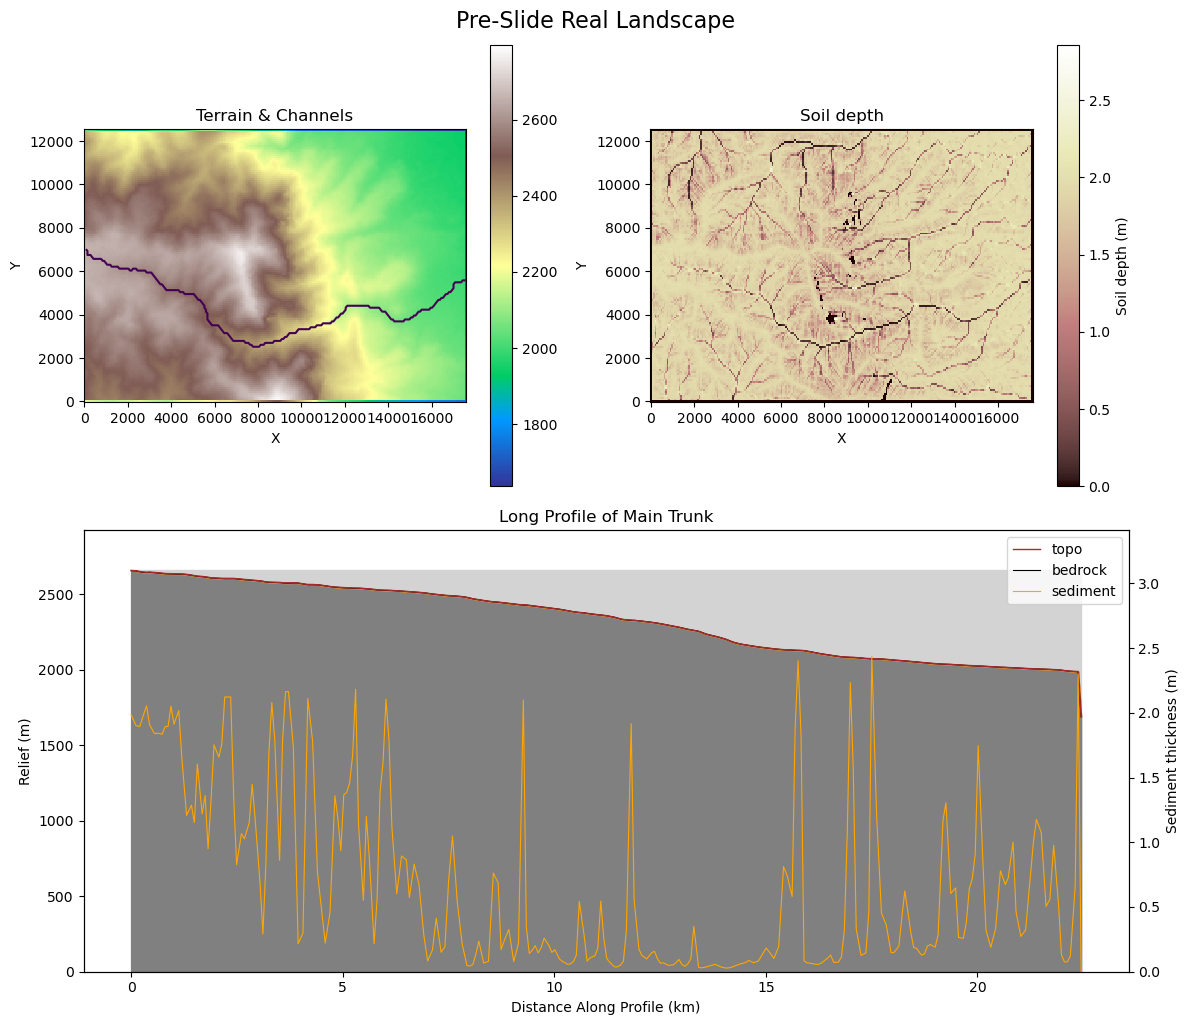

In [13]:
with open('pre-slide_reallandscape.pickle', 'rb') as g:
    mg2 = pickle.load(g)

print("Pre-Slide Real Landscape")
plot_landscape_and_profile(mg2, "Pre-Slide Real Landscape")

##### Load post-landslide landscape (using BedrockLandslider)

Post-Slide - BAD CONNECTIVITY
Before river sediment transport and incision


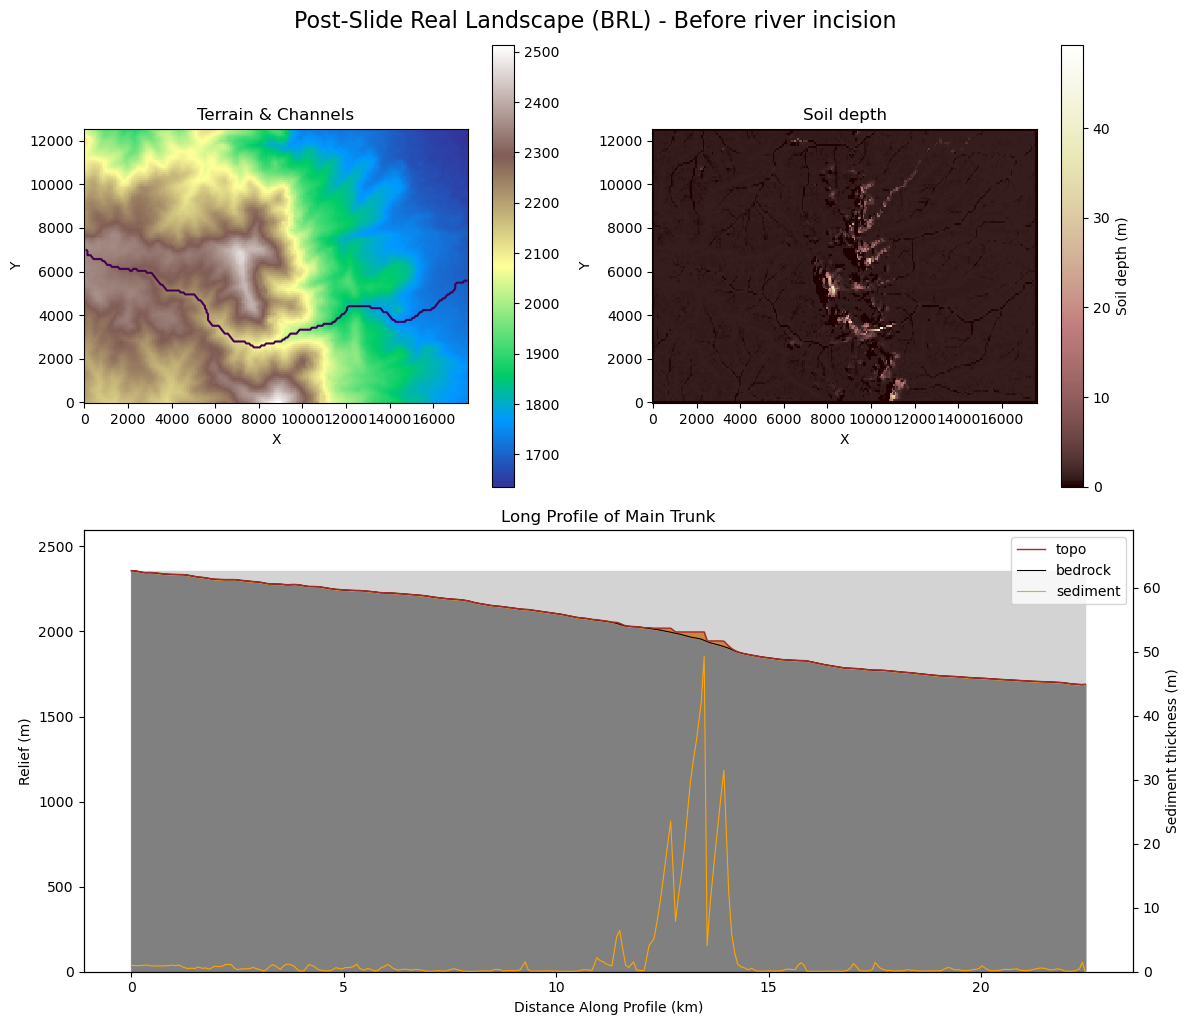

In [14]:
with open('post-slide_reallandscape_BRL.pickle', 'rb') as g:
    mg3 = pickle.load(g)

print("Post-Slide - BAD CONNECTIVITY")
print("Before river sediment transport and incision")
plot_landscape_and_profile(mg3, "Post-Slide Real Landscape (BRL) - Before river incision")

##### Run GravelBedrockEroder for different time periods

Post-Slide - BAD CONNECTIVITY
River transporting sediment through the main stream for 50 years


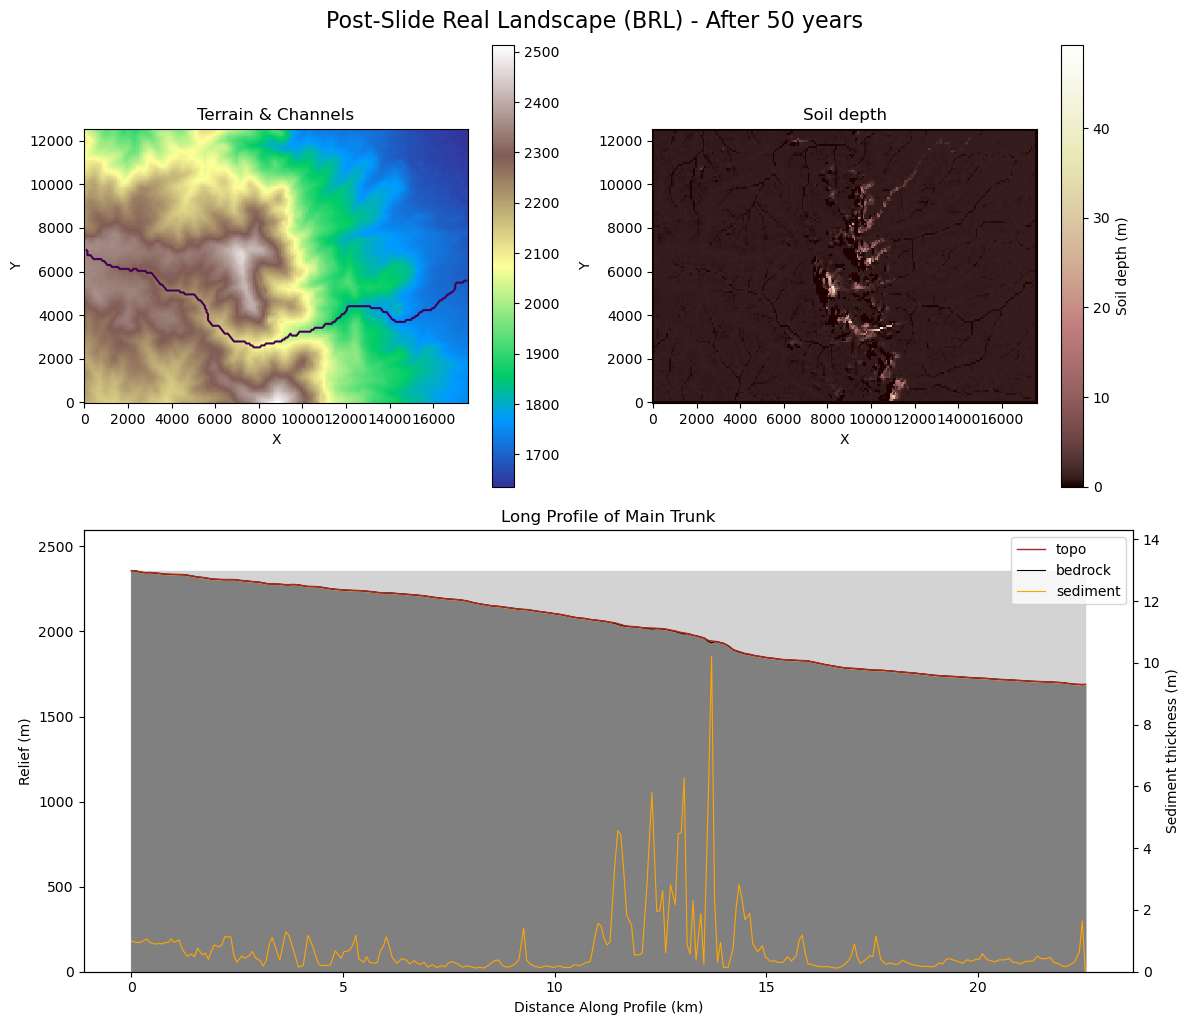

Post-Slide - BAD CONNECTIVITY
River transporting sediment through the main stream for 100 years


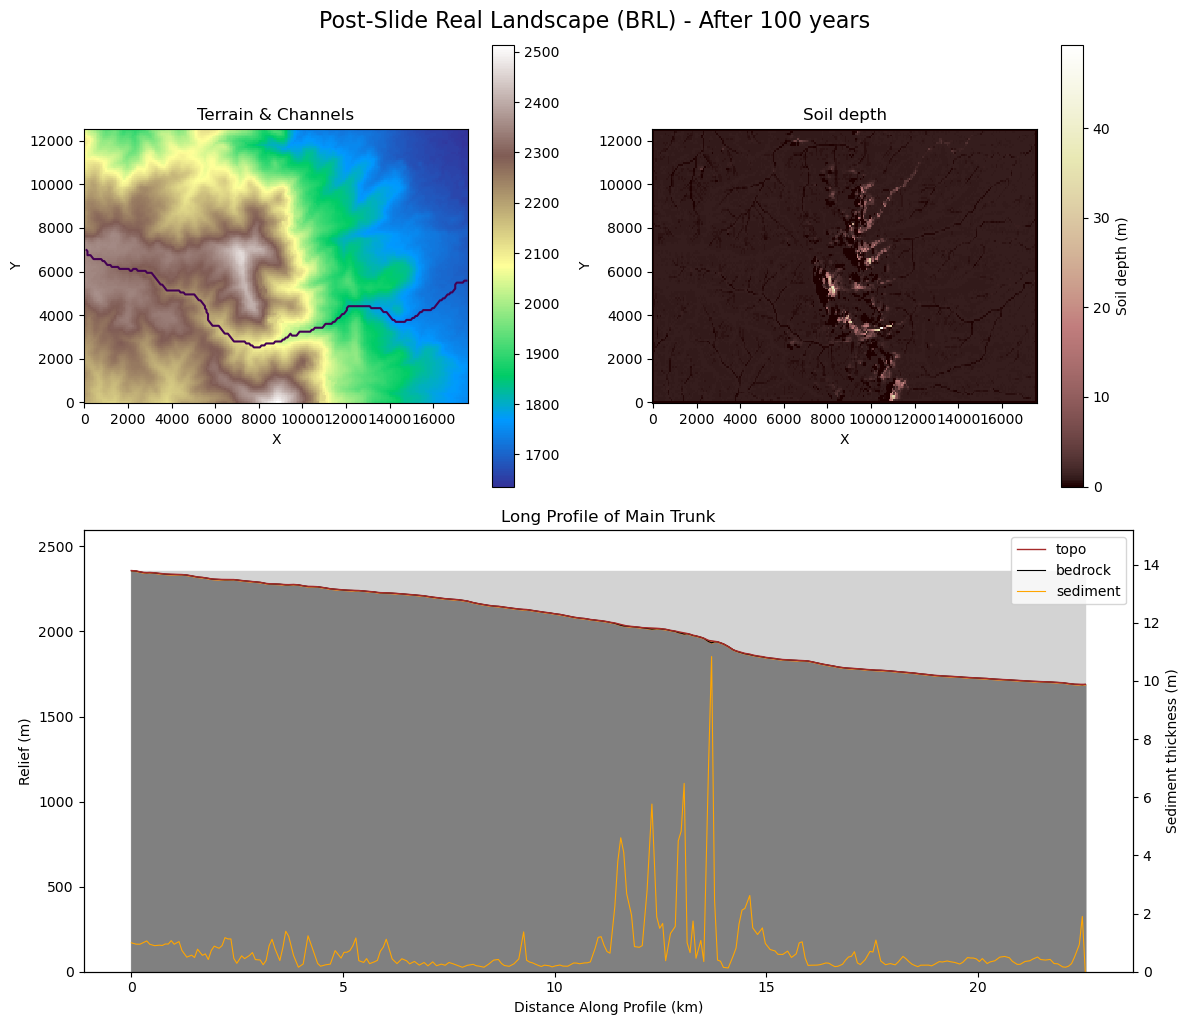

Post-Slide - BAD CONNECTIVITY
River transporting sediment through the main stream for 1000 years


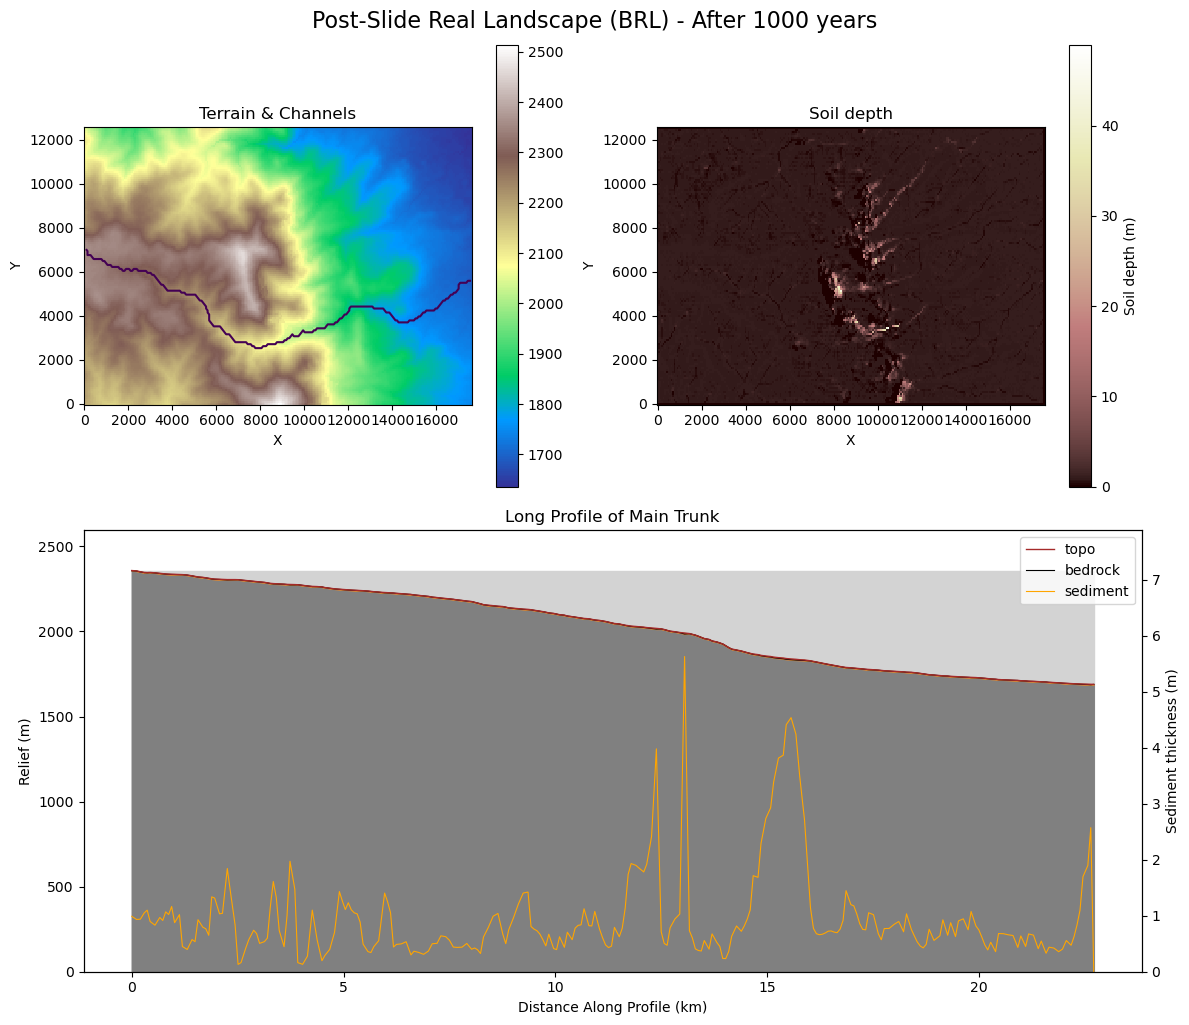

Post-Slide - BAD CONNECTIVITY
River transporting sediment through the main stream for 5000 years


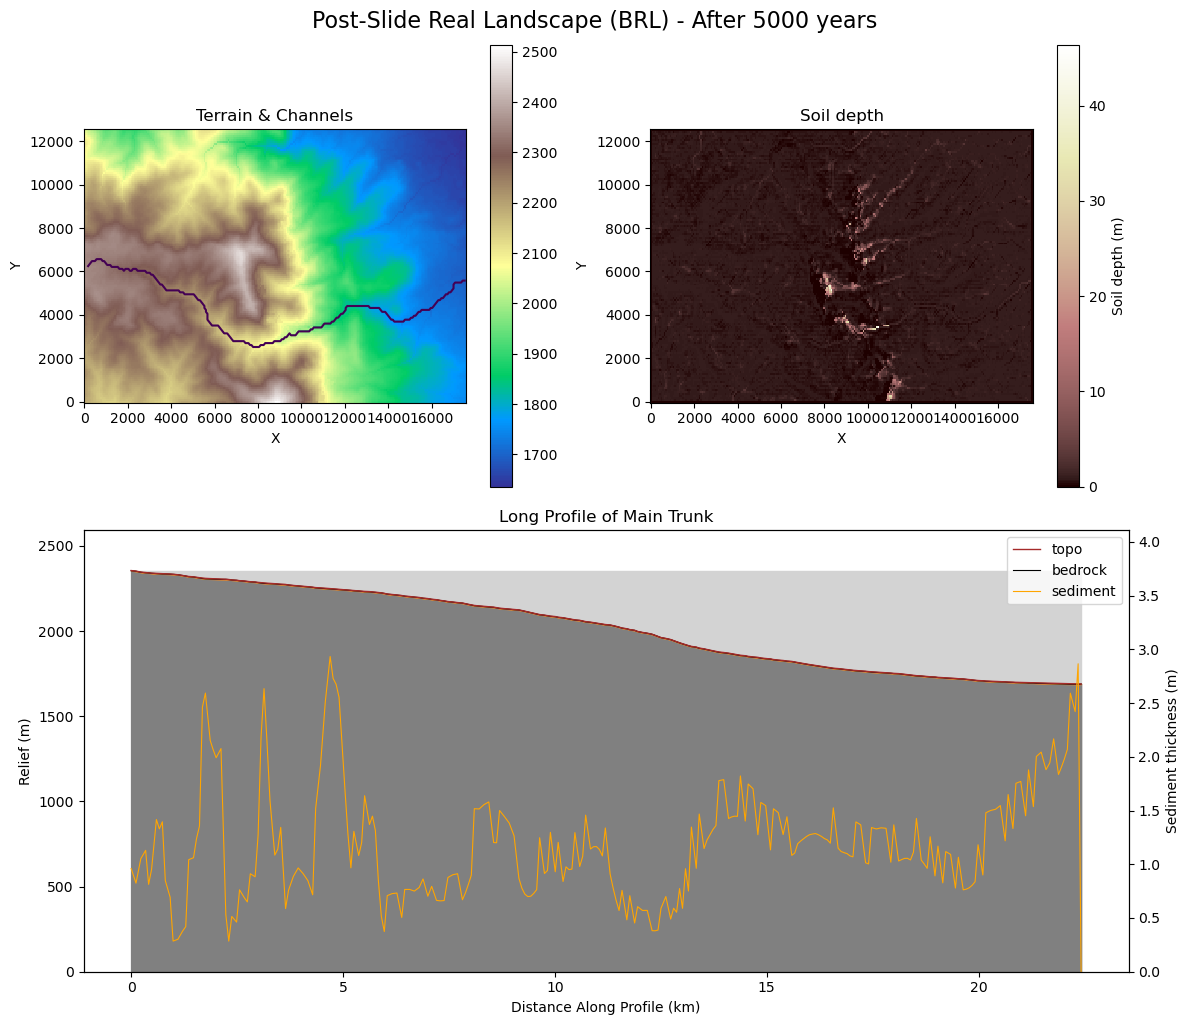

Post-Slide - BAD CONNECTIVITY
River transporting sediment through the main stream for 10000 years


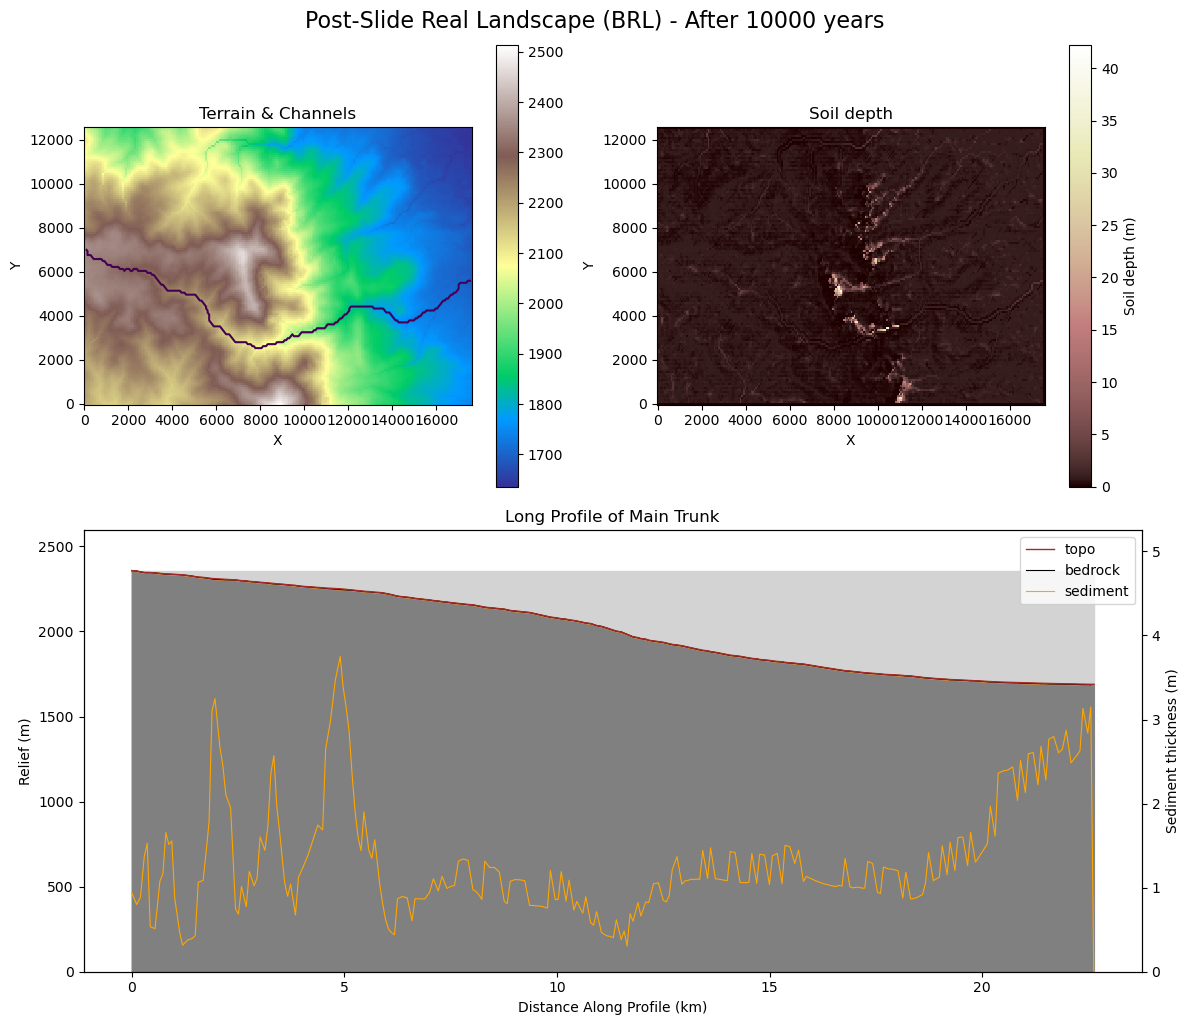

In [15]:
for years in [50, 100, 1000, 5000, 10000]:
    # Load the post-landslide landscape for each run
    mg3 = pickle.load(open('post-slide_reallandscape_BRL.pickle', 'rb'))
    
    # Initialize flow router
    fr = PriorityFloodFlowRouter(
        mg3,
        flow_metric="D8",
        separate_hill_flow=True,
        hill_flow_metric="Quinn",
        update_hill_flow_instantaneous=True,
    )
    
    # Initialize gravel-bed river erosion component
    eroder = GravelBedrockEroder(
        mg3, abrasion_coefficient=0.0005,
        coarse_fraction_from_plucking=0.1
    )
    
    # Run simulation for the specified number of years
    for i in range(20):
        # Apply uplift
        mg3.at_node["bedrock__elevation"][mg3.core_nodes] += 0.001
        mg3.at_node["topographic__elevation"][mg3.core_nodes] += 0.001
        # Route flow and perform erosion
        fr.run_one_step()
        eroder.calc_sediment_rate_of_change()
        eroder.run_one_step(years/25)
    
    print(f"Post-Slide - BAD CONNECTIVITY")
    print(f"River transporting sediment through the main stream for {years} years")
    plot_landscape_and_profile(mg3, f"Post-Slide Real Landscape (BRL) - After {years} years")

<hr>

### Summary of Main Findings

1. This notebook allows users to explore landslide-fluvial interaction using both synthetic and real landscapes.

2. Running these simulations, we found:

    * For HIGH hillslope-channel connectivity scenarios: 
        * Landslide-derived sediments can be evacuated more quickly (10^2 years timescale) in high hillslope-channel connectivity scenarios. 
        * knickpoints and kink zones can be created solely due to significant cover and tool effects caused by thick and spatially variable river bedload sediments.
    * For LOW hillslope-channel connectivity scenarios: 
        * The evacuation of landslide-derived sediments in the low-connectivity scenario appears to diffuse along the long profile for a longer duration, on the order of 10^3 years.
    * On the hillslopes, the landslide-disturbed landforms (e.g., scars, depressions) may take much longer to recover, as they require rivers to reroute and redissect the landscape.

These findings highlight the importance of considering landscape connectivity when studying the long-term effects of landslides on river systems and overall landscape evolution.